In [277]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import matplotlib as mpl
import matplotlib.ticker as mticker

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.dummy import DummyClassifier


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# plot_confusion_matrix is a handy visual tool, added in the latest version of scikit-learn
# if you are running an older version, comment out this line and just use confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingRegressor

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline # You need imblearn Pipeline for Smote work in a Pipeline

import warnings
warnings.filterwarnings('ignore')


The main aim of our project is to find the probability that a person will receive H1N1 and seasonal Flu vaccination based on many parameters.
 The data obtained from the National 2009 H1N1 Flu Survey (NHFS) contains 3 CSV files namely the training set features, the training set labels, and the test set features.
We have considered various methodologies and compared different Machine Learning and Artificial Neural Network models to predict the required probability. 
The Machine Learning algorithms such as Linear regression, Support Vector Regression, Random Forest Regression, Logistic Regression, Ridge Regression, K Nearest Neighbors, and XGBoost were used.

My goal for this project was to build a classifier to predict the seasonal flu vaccination status (did not receive flu vaccine vs. did receive the vaccine). The main purpose of the model was to make these predictions as accurately as possible, while maximizing the recall for individuals who elect not to get the vaccine. By building an accurate model and focusing on those that don't get vaccinated, I can provide insights into which factors are most important in determining vaccination status and which subgroups of the population pro-vaccination efforts/ organizations should focus on most to maximize the benefits of herd immunity.

Data files were obtained from DrivenData (Source: CDC, NCRID and NCHS (2012), National 2009 H1N1 Flu Survey). They contain the results of a phone survey conducted in 2009 which collected some basic demogrpahic information as well as information specfic to an individual's risk of developing flu-related complications (such as having a chronic medical condition), and opinions regarding vaccination and risk. The survey focused on both the seasonal flu, as well as H1N1 flu that caused a global pandemic that year. The classifiers I built were meant to predict whether or not someone was vaccinated against the seasonal flu, but the models did include information about each respondent's knowledge and concern regarding H1N1 flu as this may have impacted their choice to get vaccinated against the seasonal flu. However, information regarding and individual's opinions about the H1N1 vaccine was not used. The choice to get vaccinated against the seasonal flu in the midst of a global pandemic of a virus that attacks the respiratory system is especially relevant today given the current COVID-19 pandemic.

Once the dataset was scrubbed and the initial set of features to use for predicting was finalized, the data were split into training and test sets for building and evaluating the performance of multiple types of classifiers. I built, tested, and attempted to tune classifiers in the following categories:

- Logistic Regression
- Decision Tree
- Random Forest
- XGradient Boosted

Each of the above was tuned using GridSearchCV to test combinations of hyperparameters. The top performing classifiers from each category (excluding the decision tree category which stuck out as having the worst performance with the test data) were used as estimators in a Stacking Classifier.

In [400]:
# Read the Data
df = pd.read_csv("./Data/FullDataSet.csv")
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [378]:
df.shape

(26707, 38)

In [379]:
df.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

#### Columns to drop:

    - `respondent_id` - redundant with index
Since we are only interested in `seasonal_vaccine` as the target, let's drop the following columns specific to H1N1:

    - `h1n1_vaccine`  - other target variable we are not addressing in this project
    - `h1n1_concern`
    - `h1n1_knowledge`
    - `doctor_recc_h1n1`
    - `opinion_h1n1_vacc_effective`
    - `opinion_h1n1_sick_from_vacc`

In [401]:
df = df.drop(['respondent_id', 'h1n1_vaccine','h1n1_concern' ,'h1n1_knowledge' , 'doctor_recc_h1n1',
              'opinion_h1n1_vacc_effective' ,'opinion_h1n1_risk' ,'opinion_h1n1_sick_from_vacc'], axis = 1)     

In [354]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   behavioral_antiviral_meds    26636 non-null  float64
 1   behavioral_avoidance         26499 non-null  float64
 2   behavioral_face_mask         26688 non-null  float64
 3   behavioral_wash_hands        26665 non-null  float64
 4   behavioral_large_gatherings  26620 non-null  float64
 5   behavioral_outside_home      26625 non-null  float64
 6   behavioral_touch_face        26579 non-null  float64
 7   doctor_recc_seasonal         24547 non-null  float64
 8   chronic_med_condition        25736 non-null  float64
 9   child_under_6_months         25887 non-null  float64
 10  health_worker                25903 non-null  float64
 11  health_insurance             14433 non-null  float64
 12  opinion_seas_vacc_effective  26245 non-null  float64
 13  opinion_seas_ris

In [402]:
df

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,...,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,seasonal_vaccine
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,...,Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,1
4,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN,0
26703,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,0
26704,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN,1
26705,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg,0


In [238]:
df.isnull().sum()
# There are many null values

behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
rent_or_own                     2042
employment_status               1463
hhs_geo_region                     0
census_msa                         0
household_adults                 249
household_children               249
e

In [239]:
# Proportion of null values for the variables:
nulls = ((df.isnull().sum()*100) / len(df)).sort_values(ascending=False)
nulls[nulls > 0]

employment_occupation          50.436215
employment_industry            49.912008
health_insurance               45.957989
income_poverty                 16.561201
doctor_recc_seasonal            8.087767
rent_or_own                     7.645936
employment_status               5.477965
marital_status                  5.272026
education                       5.268282
chronic_med_condition           3.635751
child_under_6_months            3.070356
health_worker                   3.010447
opinion_seas_sick_from_vacc     2.010709
opinion_seas_risk               1.924589
opinion_seas_vacc_effective     1.729884
household_adults                0.932340
household_children              0.932340
behavioral_avoidance            0.778822
behavioral_touch_face           0.479275
behavioral_large_gatherings     0.325757
behavioral_outside_home         0.307036
behavioral_antiviral_meds       0.265848
behavioral_wash_hands           0.157262
behavioral_face_mask            0.071142
dtype: float64

In [240]:
df.health_insurance.value_counts(dropna=False)

1.0    12697
NaN    12274
0.0     1736
Name: health_insurance, dtype: int64

In [241]:
df[df.health_insurance.isnull() & df.employment_occupation.isnull() 
   & df.employment_industry.isnull()][['employment_occupation', 'health_insurance', 'employment_industry']]

,employment_occupation,health_insurance,employment_industry
3,NaN,NaN,NaN
20,NaN,NaN,NaN
27,NaN,NaN,NaN
53,NaN,NaN,NaN
54,NaN,NaN,NaN
...,...,...,...
26684,NaN,NaN,NaN
26687,NaN,NaN,NaN
26700,NaN,NaN,NaN
26702,NaN,NaN,NaN


In [121]:
df.income_poverty.value_counts(dropna=False)

<= $75,000, Above Poverty    12777
> $75,000                     6810
NaN                           4423
Below Poverty                 2697
Name: income_poverty, dtype: int64

In [120]:
df[df.income_poverty.isnull() & df.health_insurance.isnull() 
   & df.employment_occupation.isnull() & df.employment_industry.isnull()][['income_poverty']]

,income_poverty
54,NaN
64,NaN
75,NaN
84,NaN
94,NaN
...,...
26643,NaN
26665,NaN
26672,NaN
26675,NaN


* `employment_occupation`, `employment_industry`, and `health_insurance` and `income_poverty` columns contain the most missing values, with null values making up 50.4%, 49.9%, 46% and 16.6% of the column, respectively.
* But those demographic variables could be really important for the classification.
* Half of the people who did not give an asnwer for `health_insurance` also did not give an answer for `occupation`. 
* Half of the people who did not give an asnwer for `income_poverty` also did not give an answer for `health_insurance`. 
* However, it is still not enough evidence to fill in missing values for `income_poverty` or `health_insurance` with the lowest possible score. 


In [326]:
corr = abs(df.corr()['health_insurance']).sort_values(ascending = False)
corr

health_insurance               1.000000
seasonal_vaccine               0.200858
doctor_recc_seasonal           0.117195
opinion_seas_vacc_effective    0.091247
household_adults               0.078697
household_children             0.069402
chronic_med_condition          0.066088
opinion_seas_sick_from_vacc    0.065886
behavioral_antiviral_meds      0.063988
behavioral_outside_home        0.061381
behavioral_large_gatherings    0.059000
opinion_seas_risk              0.050232
health_worker                  0.046680
behavioral_face_mask           0.040257
behavioral_avoidance           0.032662
behavioral_wash_hands          0.031919
child_under_6_months           0.026836
behavioral_touch_face          0.011024
Name: health_insurance, dtype: float64

In [272]:
df.describe()
# Many of the numerical variables appear as ordinal in nature. 

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,seasonal_vaccine
count,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,25736.000000,25887.000000,25903.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000
mean,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.329735,0.283261,0.082590,0.111918,4.025986,2.719162,2.118112,0.886499,0.534583,0.465608
std,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.470126,0.450591,0.275266,0.315271,1.086565,1.385055,1.332950,0.753422,0.928173,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,2.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.000000,4.000000,4.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,3.000000,3.000000,1.000000


#### Is the target variable balanced or inbalanced? 
* Let's see the count values for those people who received and did not receive the seasonal vaccine:
* Based on below graph it appears as though the seasonal flu vaccine target has **balanced** classes. 

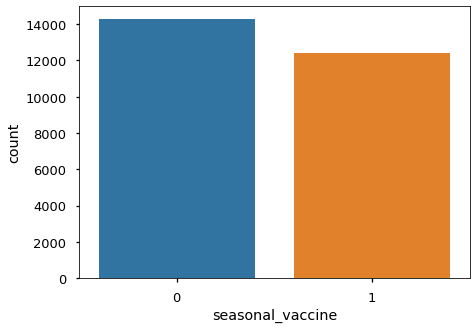

In [520]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.countplot(df['seasonal_vaccine'], ax= ax);

In [245]:
# Create a new df with cat codes - numbers - (temporarily) to see the distibution of all values using a histogram. 
df_cat = df
df_cat = df_cat.apply(lambda x: x.astype('category').cat.codes)

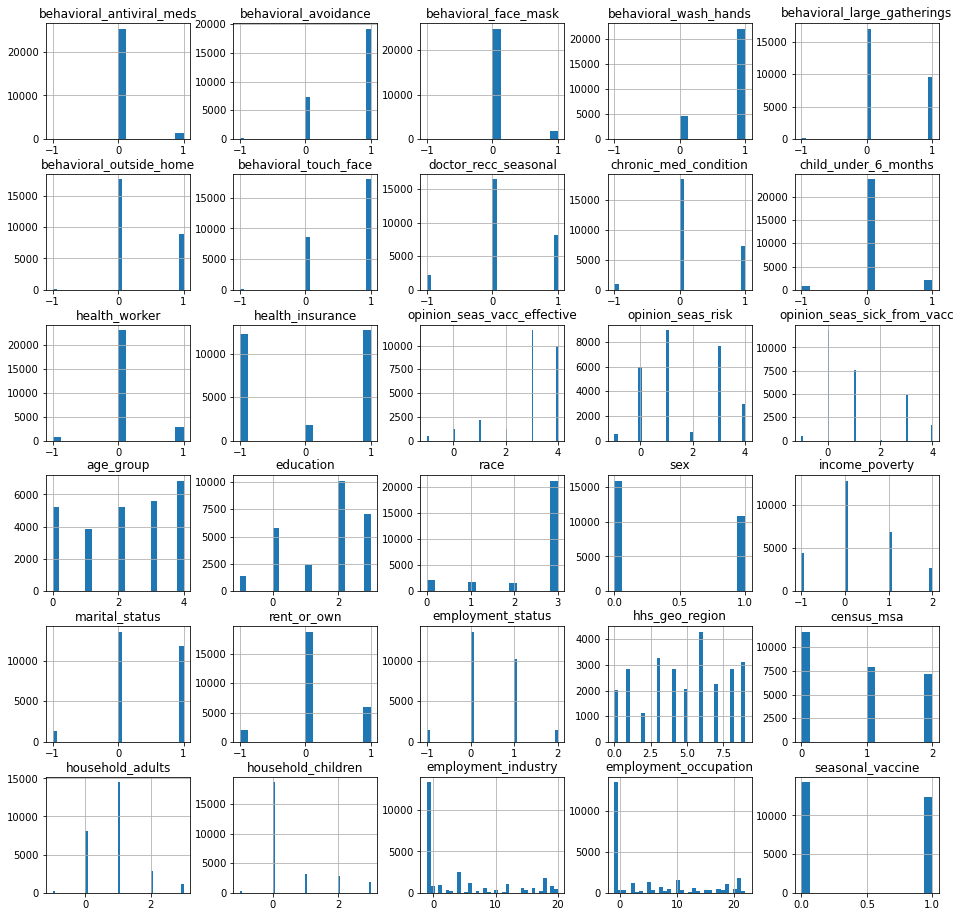

In [246]:
# Check out the distribution of all variables
df_cat.hist(bins='auto', edgecolor='none', figsize=(16,16));

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   behavioral_antiviral_meds    26636 non-null  float64
 1   behavioral_avoidance         26499 non-null  float64
 2   behavioral_face_mask         26688 non-null  float64
 3   behavioral_wash_hands        26665 non-null  float64
 4   behavioral_large_gatherings  26620 non-null  float64
 5   behavioral_outside_home      26625 non-null  float64
 6   behavioral_touch_face        26579 non-null  float64
 7   doctor_recc_seasonal         24547 non-null  float64
 8   chronic_med_condition        25736 non-null  float64
 9   child_under_6_months         25887 non-null  float64
 10  health_worker                25903 non-null  float64
 11  health_insurance             14433 non-null  float64
 12  opinion_seas_vacc_effective  26245 non-null  float64
 13  opinion_seas_ris

* -1 represents null values and there are many variable with high number of null values. 
* All variables are appear as **categorical** in nature (possibly because the data was a survey data).
* Many of variables in float type are actually **binary (yes/no)** and they will be treated as **categorical**. 
* Some of variables in float type are **ordinal** (some sense of ordering to its categories), so they will be treated as **numerical**. 
* The variables in object type are **nominal** (no intrinsic ordering to its categories), so they will be treated as **categorical**. 
* Only for `health_insurance` it does not make sence to fill in null values with the most common (1), since half of the data is null. We will treat it as categorical and assign a diffefent value to the missing values. 

### Binary Columns:

In [403]:
binary_columns = ['behavioral_antiviral_meds', 'behavioral_avoidance',
                  'behavioral_face_mask', 'behavioral_wash_hands',
                  'behavioral_large_gatherings', 'behavioral_outside_home',
                  'behavioral_touch_face', 'doctor_recc_seasonal',
                  'chronic_med_condition', 'child_under_6_months', 'health_worker']

In [404]:
for col in binary_columns:
    #df[col] = pd.Categorical(df[col])
    df[col] = df[col].astype('object')
    # df[col] = df[col].cat.codes
      
    # df[col] = df[col].cat.codes

In [406]:
df.doctor_recc_seasonal.value_counts(dropna =False)

0.0    16453
1.0     8094
NaN     2160
Name: doctor_recc_seasonal, dtype: int64

### `health_insurance`:

In [407]:
# Convert health_insurance into a categorical variable so the null values would be of anoter categpry level
df['health_insurance'] = df['health_insurance'].astype("object")

# Replacing the string values with numerical values. 
dic = {0:'No', 1:'Yes'}
df.replace({"health_insurance": dic}, inplace=True)
df["health_insurance"].value_counts(dropna=False)

Yes    12697
NaN    12274
No      1736
Name: health_insurance, dtype: int64

In [408]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   behavioral_antiviral_meds    26636 non-null  object 
 1   behavioral_avoidance         26499 non-null  object 
 2   behavioral_face_mask         26688 non-null  object 
 3   behavioral_wash_hands        26665 non-null  object 
 4   behavioral_large_gatherings  26620 non-null  object 
 5   behavioral_outside_home      26625 non-null  object 
 6   behavioral_touch_face        26579 non-null  object 
 7   doctor_recc_seasonal         24547 non-null  object 
 8   chronic_med_condition        25736 non-null  object 
 9   child_under_6_months         25887 non-null  object 
 10  health_worker                25903 non-null  object 
 11  health_insurance             14433 non-null  object 
 12  opinion_seas_vacc_effective  26245 non-null  float64
 13  opinion_seas_ris

### Multicollinearity:
* Let's see how the variables correlate with one another. 
* Multicollinearity is not a big concern for logistic regression but if there are some variables that stand out with their high correlation we might choose to remove those variables: 


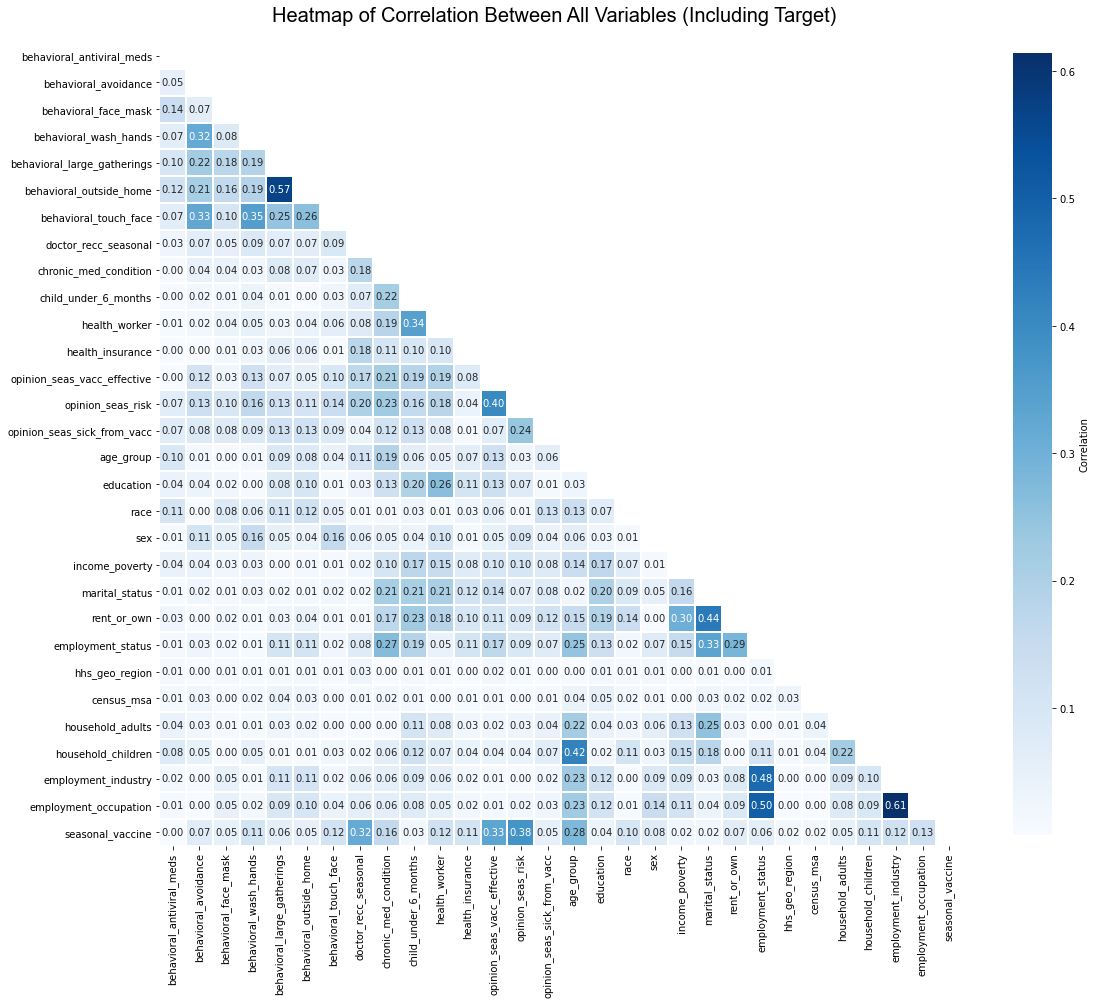

In [247]:
# Heat Map showing the correlation between all variables including the target
corr = df_cat.corr().abs()

fig, ax=plt.subplots(figsize=(18,18))
matrix = np.triu(corr) # Getting the Upper Triangle of the correlation matrix
cbar_kws={"label": "Correlation", "shrink":0.8}
heatmap = sns.heatmap(data = corr, cmap='Blues', linewidths = 1, square= True,  ax=ax, annot=True, mask=matrix, fmt= ".2f", cbar_kws=cbar_kws) 
fig.suptitle('Heatmap of Correlation Between All Variables (Including Target)', fontsize=20, y=.84, x = .43, fontname='Arial');
heatmap;

In [248]:
def show_corr_pairs(data):
    dataCorr = data.corr().abs()
    dataCorr = dataCorr.mask(np.triu(np.ones(dataCorr.shape)).astype(np.bool)) # convert upper triangle of values to NaN to remove repeated values from the table
    dataCorr = dataCorr.stack().reset_index().sort_values(0, ascending=False) #0 is the column automatically generated by the stacking
    dataCorr = dataCorr[(dataCorr[0]>.7) & (dataCorr[0]<1)]
    dataCorr =  dataCorr.rename(columns = {'level_0': 'var1', 'level_1': 'var2', 0:'corrcoef'})
    return dataCorr
show_corr_pairs(df_cat)

,var1,var2,corrcoef


### Let's see the proportion of people with health insurance at each level of some other variables:
Similar idea taken from:
https://drivendata.co/blog/predict-flu-vaccine-data-benchmark/

* We will focus on one variable first to see how we can extract this information, and then generalize it to all variables creating a function. And then we will use it in a loop to generalize over multiple variables. 

In [135]:
# Counts for having / not having health_insurance for each race:
counts = df_insurance[['education','health_insurance']].groupby(['education', 'health_insurance']).size().unstack('health_insurance')
counts

health_insurance,0,1
education,,
12 Years,572,2810
< 12 Years,314,1019
College Graduate,318,5272
Some College,517,3515


In [136]:
# Getting the total numbers:
total_counts = counts.sum(axis=1)
total_counts

education
12 Years            3382
< 12 Years          1333
College Graduate    5590
Some College        4032
dtype: int64

In [137]:
# Getting the proportion of having / not having health_insurance for each race:
props = counts[[0,1]].multiply(100).div(total_counts, axis=0)  
props

health_insurance,0,1
education,,
12 Years,16.913069,83.086931
< 12 Years,23.555889,76.444111
College Graduate,5.688730,94.311270
Some College,12.822421,87.177579


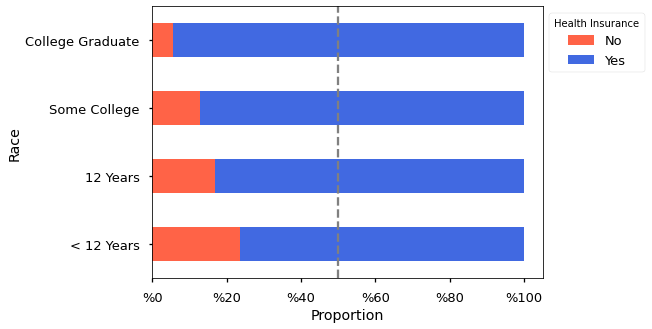

In [141]:
# Bar plot:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(7, 5))
    props.sort_values(by = 1).plot.barh(stacked=True, color = ['tomato','royalblue'], ax=ax)
    ax.legend(bbox_to_anchor=(1, 1), labels = ['No', 'Yes'], title='Health Insurance')
    ax.set_ylabel("Race")
    ax.set_xlabel("Proportion")
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) 
    ax.axvline(x= 50, ymin=0, ymax=1, color='grey', linestyle='--') 

In [145]:
# Put this in a function so that we can loop it through each variable:

def proportion_plot(column, target, ax):  # if ax = None no axis sent and default is ax = None
    
    counts = df[[column,target]].groupby([column, target]).size().unstack(target)
    props = counts[[0,1]].multiply(100).div(counts.sum(axis=1), axis=0)  
    
    props.sort_values(by = 1).plot.barh(stacked=True, color = ['tomato','royalblue'], ax = ax)
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) 
    ax.axvline(x= 50, ymin=0, ymax=1, color='grey', linestyle='--') 
    ax.legend().remove()

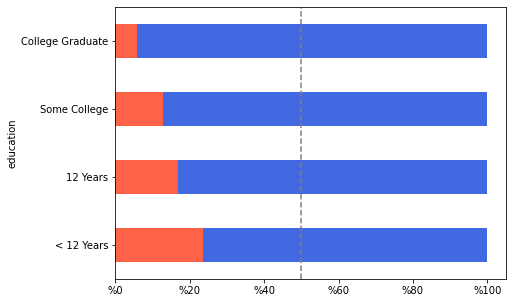

In [146]:
fig, ax = plt.subplots(figsize=(7,5))  
proportion_plot('education', 'health_insurance', ax);

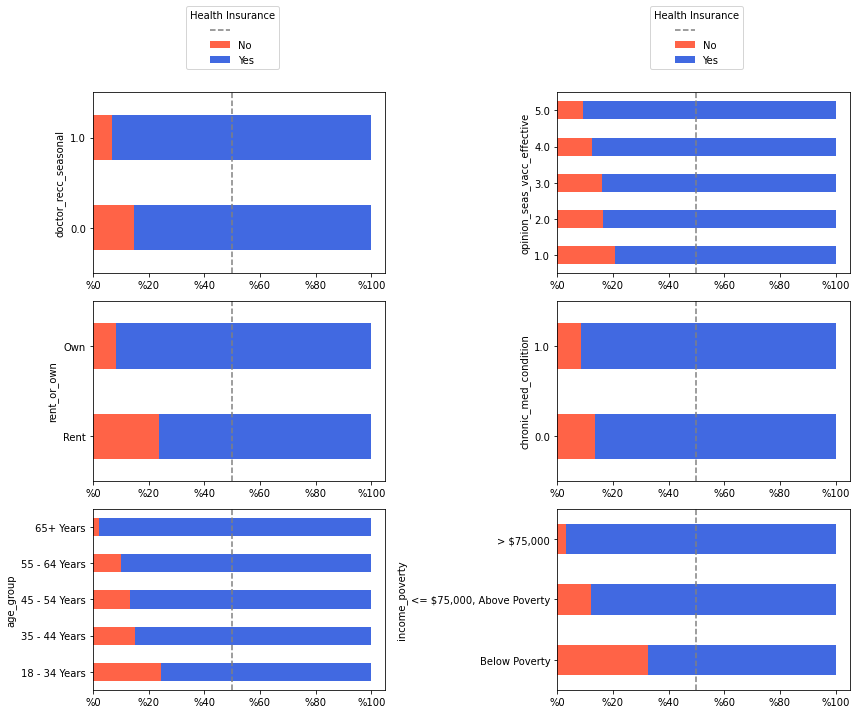

In [149]:
columns = ['doctor_recc_seasonal', 'opinion_seas_vacc_effective', 'rent_or_own', 'chronic_med_condition', 'age_group', 'income_poverty']

nrows = 3
ncols= 2

fig, ax_list = plt.subplots(nrows = nrows, ncols = ncols, figsize=(12,10))  

j=0
for i in range(nrows):
    for y in range(ncols):
        proportion_plot(columns[j], 'health_insurance', ax = ax_list[i,y]) # need to use index for column because otherwise it does not ititrate.
        j = j+1

ax_list[0, 0].legend(bbox_to_anchor=(0.3, 1.1), labels = [None, 'No', 'Yes'], title='Health Insurance')
ax_list[0, 1].legend(bbox_to_anchor=(0.3, 1.1), labels = [None, 'No', 'Yes'], title='Health Insurance')

fig.tight_layout();


IndexError: index 29 is out of bounds for axis 0 with size 29

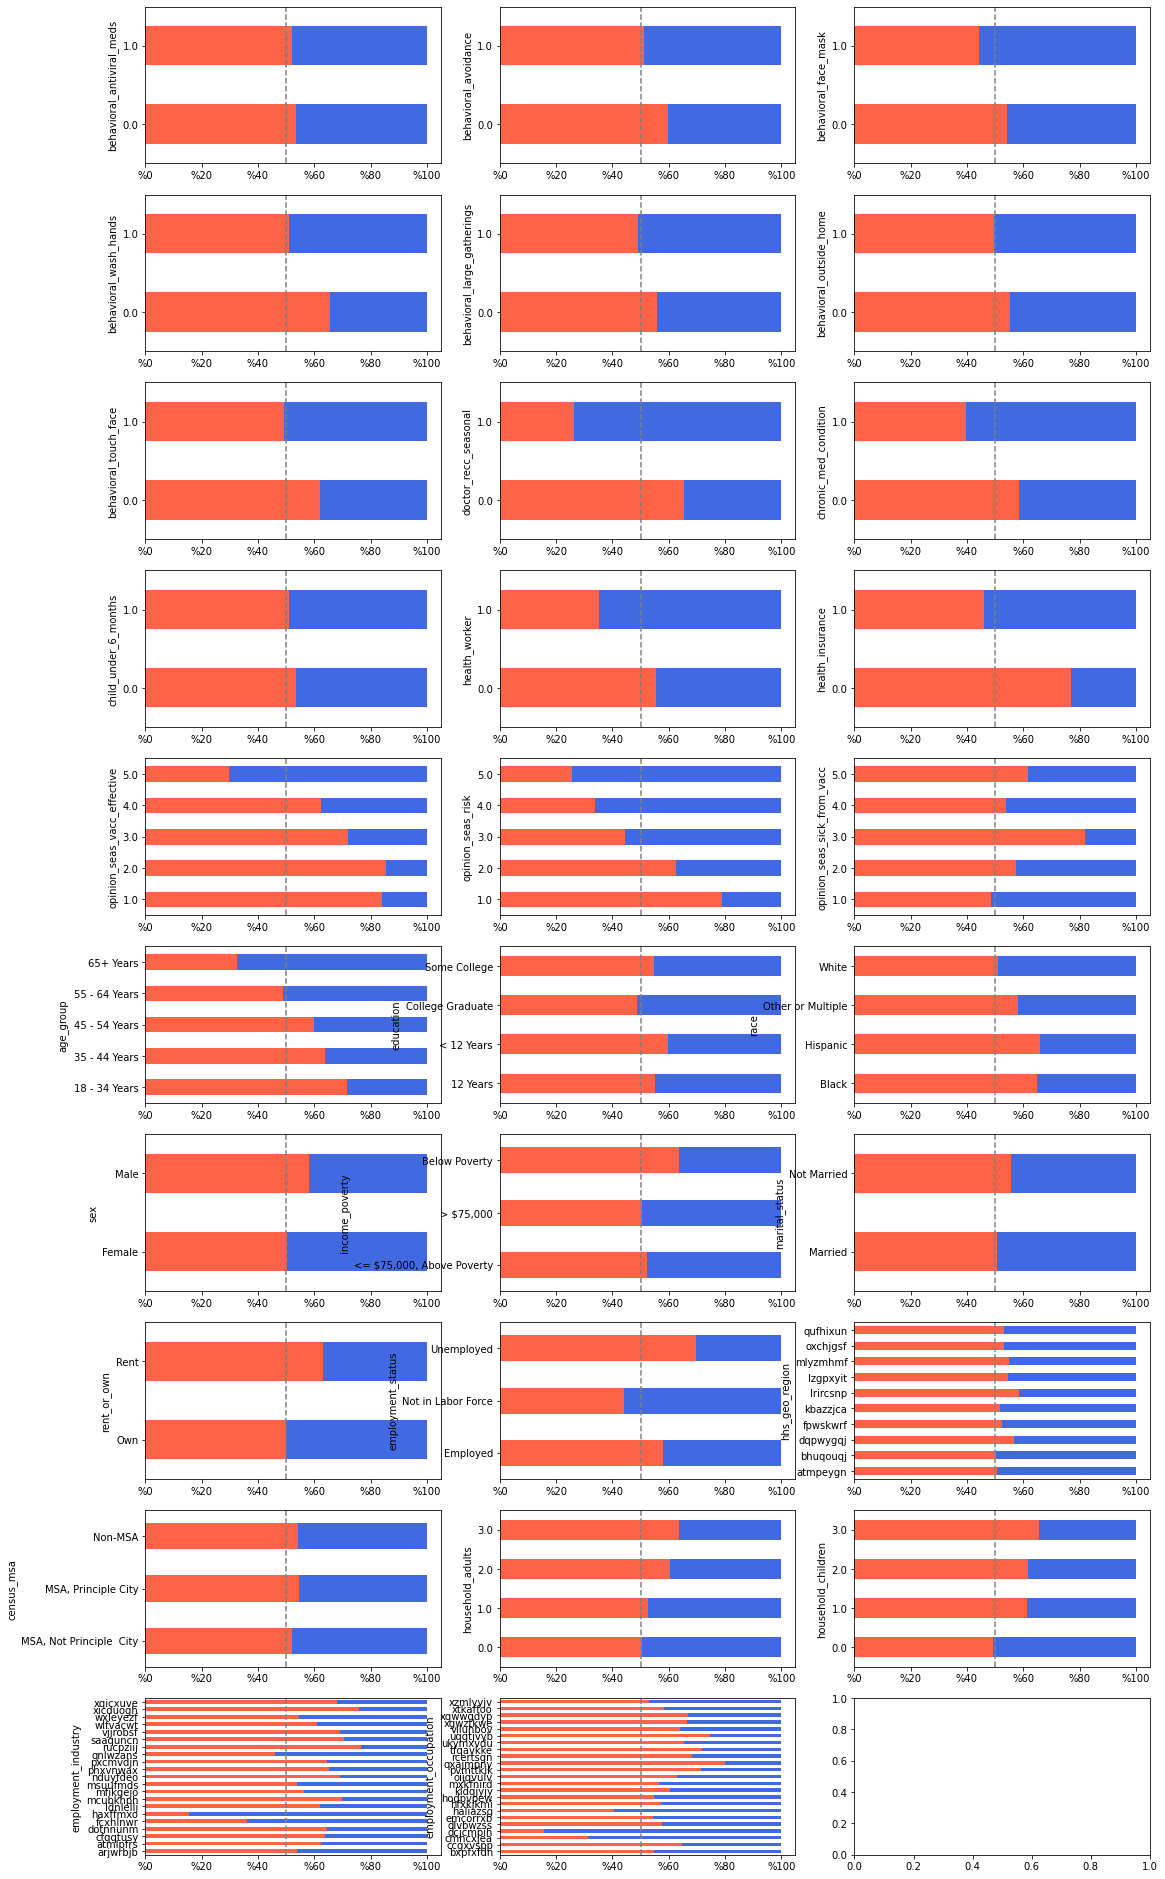

In [205]:
columns = df.columns.drop('seasonal_vaccine')

nrows = (len(df.columns)//3)
ncols= 3

fig, ax_list = plt.subplots(nrows = nrows, ncols = ncols, figsize=(18,34))  

j=0
for i in range(nrows):
    for y in range(ncols):
        proportion_plot(columns[j], 'seasonal_vaccine', ax = ax_list[i,y]) # need to use index for column because otherwise it does not ititrate.
        j = j+1

ax_list[0, 0].legend(bbox_to_anchor=(0.3, 1.1), labels = [None, 'No', 'Yes'], title='Seasonal Vaccine')
ax_list[0, 1].legend(bbox_to_anchor=(0.3, 1.1), labels = [None, 'No', 'Yes'], title='Seasonal Vaccine')
ax_list[0, 2].legend(bbox_to_anchor=(0.3, 1.1), labels = [None, 'No', 'Yes'], title='Seasonal Vaccine')

fig.tight_layout();

### Specify X and y:

In [409]:
X = df.drop('seasonal_vaccine', axis=1)
y = df['seasonal_vaccine']

In [410]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   behavioral_antiviral_meds    26636 non-null  object 
 1   behavioral_avoidance         26499 non-null  object 
 2   behavioral_face_mask         26688 non-null  object 
 3   behavioral_wash_hands        26665 non-null  object 
 4   behavioral_large_gatherings  26620 non-null  object 
 5   behavioral_outside_home      26625 non-null  object 
 6   behavioral_touch_face        26579 non-null  object 
 7   doctor_recc_seasonal         24547 non-null  object 
 8   chronic_med_condition        25736 non-null  object 
 9   child_under_6_months         25887 non-null  object 
 10  health_worker                25903 non-null  object 
 11  health_insurance             14433 non-null  object 
 12  opinion_seas_vacc_effective  26245 non-null  float64
 13  opinion_seas_ris

In [411]:
binary_columns = ['behavioral_antiviral_meds', 'behavioral_avoidance',
                  'behavioral_face_mask', 'behavioral_wash_hands',
                  'behavioral_large_gatherings', 'behavioral_outside_home',
                  'behavioral_touch_face', 'doctor_recc_seasonal',
                  'chronic_med_condition', 'child_under_6_months', 'health_worker']

In [412]:
cat_columns = ['health_insurance','age_group', 'education', 'race', 'sex',
       'income_poverty', 'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']

In [389]:
df.columns

Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'age_group', 'education', 'race', 'sex',
       'income_poverty', 'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'household_adults',
       'household_children', 'employment_industry', 'employment_occupation',
       'seasonal_vaccine'],
      dtype='object')

### Test Train split the data:

In [413]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train_binary = X_train[binary_columns]
X_train_nums = X_train.select_dtypes('float64')
X_train_cats = X_train[cat_columns]

In [414]:
X_train_binary

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker
25194,0,0,0,0,0,0,0,NaN,0,0,0
14006,0,1,0,1,0,0,0,1,1,1,0
11285,0,0,0,0,0,0,0,0,0,0,0
2900,0,0,0,0,0,0,0,0,1,0,0
19083,1,1,0,1,1,1,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
21575,0,0,0,1,0,0,1,0,0,0,0
5390,0,0,0,1,0,0,1,NaN,0,0,0
860,0,1,0,0,0,0,1,0,0,0,0
15795,0,1,0,1,0,0,1,1,1,0,1


In [393]:
assert ((len(X_train_nums.columns) + len(X_train_cats.columns) + len(X_train_binary.columns)) == len(X.columns))

# Logistic Regression:

## Preprocessing Steps:
- **NA imputation** for both ordinal/numerical and categorical variables
    * For the ordinal variables, let's impute with the median.
    * For the categorical variables, let's impute with the most frequent. 
- **One-Hot-Encoding** for the categorical variables
- **Scaling** for the ordinal/numerical variables

### "Preprocessing" pipeline for the numerical/ordinal and categorical/nominal columns:

In [415]:
binary_preprocessing = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='most_frequent'))
])

numerical_preprocessing = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_preprocessing = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(drop='first', sparse=False))
])

#grab columns out of a pandas data frame and then apply a specified transformer.
preprocessor = ColumnTransformer(transformers=[
    ('binary_preprocess', binary_preprocessing, X_train_binary.columns),
    ('num_preprocess', numerical_preprocessing, X_train_nums.columns),
    ('cat_preprocess', categorical_preprocessing, X_train_cats.columns)] # remainder='passthrough'
)
preprocessor

ColumnTransformer(transformers=[('binary_preprocess',
                                 Pipeline(steps=[('simple_imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_seasonal',
       'chronic_med...
                                 Pipeline(steps=[('simple_imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 

### Model pipeline:

In [416]:
logreg_model = Pipeline([
    ("preprocessor", preprocessor),
    ("estimator", LogisticRegression(random_state=42)) # use random state so that your model results are reproducable. 
])

# Train model
logreg_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary_preprocess',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'do...
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['

In [417]:
# The data frame after preprocessing:
cat_feature_names = preprocessor.named_transformers_['cat_preprocess'].named_steps['ohe'].get_feature_names(X_train_cats.columns)
feature_names = np.r_[X_train_binary.columns, X_train_nums.columns, cat_feature_names]

X_train_transformed = pd.DataFrame(preprocessor.fit_transform(X_train), columns= feature_names)
X_train_transformed

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,...,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,1,1,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20025,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20026,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20027,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20028,0,1,0,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [418]:
X_train_transformed.isnull().sum()

behavioral_antiviral_meds         0
behavioral_avoidance              0
behavioral_face_mask              0
behavioral_wash_hands             0
behavioral_large_gatherings       0
                                 ..
employment_occupation_vlluhbov    0
employment_occupation_xgwztkwe    0
employment_occupation_xqwwgdyp    0
employment_occupation_xtkaffoo    0
employment_occupation_xzmlyyjv    0
Length: 95, dtype: int64

In [456]:
def baseline_model_evaluation(model):
# Print classification Report for the trained set
    y_true = y_train
    y_pred = model.predict(X_train)
    divider = ('----' * 14) 
    table_title = 'Classification Report - Train Set:'
    table = classification_report(y_true, y_pred, digits=3)
    print('\n', divider, table_title, divider, table, divider, divider, '\n' , sep='\n') 
        
# Perform cross-validation with roc_auc
# cross_val_score, returns the score from all k folds. 
# It is generally preferable, but you need to shuffle the data first
# Find Roc_Auc Scores for both test and train 
    score_train_cv = cross_val_score(estimator=model, X=X_train,  y=y_train, 
                         cv=StratifiedKFold(shuffle=True, random_state = 42), scoring='roc_auc').mean()
    score_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    print(f"Mean Cross Validated Roc_Auc Score: {score_train_cv :.4%}")    
    print(f"Train Roc_Auc Score: {score_train :.4%}") 
        
    print('\n', divider, divider, '\n' , sep='\n')

In [457]:
baseline_model_evaluation(logreg_model);



--------------------------------------------------------
Classification Report - Train Set:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.784     0.809     0.796     10638
           1      0.776     0.748     0.761      9392

    accuracy                          0.780     20030
   macro avg      0.780     0.778     0.779     20030
weighted avg      0.780     0.780     0.780     20030

--------------------------------------------------------
--------------------------------------------------------


Mean Cross Validated Roc_Auc Score: 85.2473%
Train Roc_Auc Score: 85.6040%


--------------------------------------------------------
--------------------------------------------------------




Let’s first understand the interpretation of doing it the both way.

Building an AUC ROC curve will simply explain the maximum possible variable separability of the model. Computing the AUC ROC on train set, will tell if model is confident in it’s learning or not. This is like a student re-answering the same question when taught by teacher during the class.

AUC ROC on test set will tell, how good it performed on unknown dataset. So this is like answering a different question based upon a concept learnt.

The difference between the two if is very large, you the know the student doesn’t understand concepts well, which is nothing but model “overfitting”. However, if the training set’s AUCROC is itself bad, then the model is not learning in the first place any pattern.

It depends what you want. If your focus is just good predictions, then a decent AUC ROC on test set is good to go. But if you want to delve deeper and understand feature importance and model characteristics, check out metrics on train set too.

Some people also go for train, validation and test, where they tune parameter on train, AUCROC based model selection and threshold selection on validation set, and final assessment on test set.






## Parameter Tuning with GridSearchCV

#### Hyperparameters for logistic regression:
* **penalty** — Specify the norm of the penalty.
* **C** — Inverse of regularization strength; smaller values specify stronger regularization.
* **solver** — Algorithm to use in the optimization problem.
* **max_iter** — Maximum number of iterations taken for the solvers to converge.


In [458]:
# Parameter Grid
# There should be two underscores between estimator name and it's parameters in a Pipeline

parameters = {
    'estimator__penalty' : ['l1','l2'], 
    'estimator__fit_intercept':[True, False],
    'estimator__C'       : [0.001,0.01,0.1,1,10,100,1000], #np.logspace(-3,3,7)
    'estimator__solver'  : ['lbfgs', 'liblinear'],
}

# Create the grid, with "logreg_pipeline" as the estimator
best_logreg = GridSearchCV(estimator = logreg_model,    # model
                          param_grid = parameters,     # hyperparameters
                          scoring ='roc_auc',          # metric for scoring
                          cv = 5)                      # number of folds for cross-validation

# Train the pipeline (tranformations & predictor)
best_logreg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('binary_preprocess',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home'...
       'income_poverty', 'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employment_occupation'],
      dtype='object'))])),
                                       ('estimator',
                                        LogisticRegression(random_state=42))]),

In [422]:
print("Tuned Hyperparameters :", best_logreg.best_params_)

Tuned Hyperparameters : {'estimator__C': 0.1, 'estimator__fit_intercept': True, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}


In [533]:
def bestfit_model_evaluation(model):
    
    with plt.style.context('seaborn-talk'):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

        # Plot confusion matrix for the test set
        plot_confusion_matrix(model.best_estimator_, X_test, y_test, normalize = 'true', ax=ax1,  cmap = 'Blues') 
        ax1.grid(False) 
        ax1.set_title("Confusion Matrix - Test")
        
        # plot Roc curve for the test and train
        plot_roc_curve(model.best_estimator_, X_train, y_train, ax=ax2, name ='Train ROC curve' )
        plot_roc_curve(model.best_estimator_, X_test, y_test, ax=ax2, name ='Test ROC curve' )
        ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('Receiver operating characteristic (ROC) Curve')
        plt.show()
        
        # Print classification Scores for the test set
        y_true = y_test
        y_pred = model.best_estimator_.predict(X_test)
        divider = ('----' * 14) 
        table_title = 'Classification Report - Test:'
        table = classification_report(y_true, y_pred, digits=3)
        print('\n', divider, table_title, divider, table, divider, divider, '\n' , sep='\n') 
        
        # Print roc_auc
        # model.best_estimator_ runs faster
        score_train_cv = cross_val_score(estimator=model.best_estimator_, X=X_train,  y=y_train, 
                                         cv=StratifiedKFold(shuffle=True, random_state = 42), scoring='roc_auc').mean()
        score_train = roc_auc_score(y_train, model.best_estimator_.predict_proba(X_train)[:, 1]) 
        score_test = roc_auc_score(y_test, model.best_estimator_.predict_proba(X_test)[:, 1])
        
        print(f"Mean Cross Validated Roc_Auc Score: {score_train_cv :.4%}")    
        print(f"Train Roc_Auc Score: {score_train :.4%}")  
        print(f"Test Roc_Auc Score: {score_test :.4%}")    

        print('\n', divider, divider, '\n' , sep='\n')
        
    

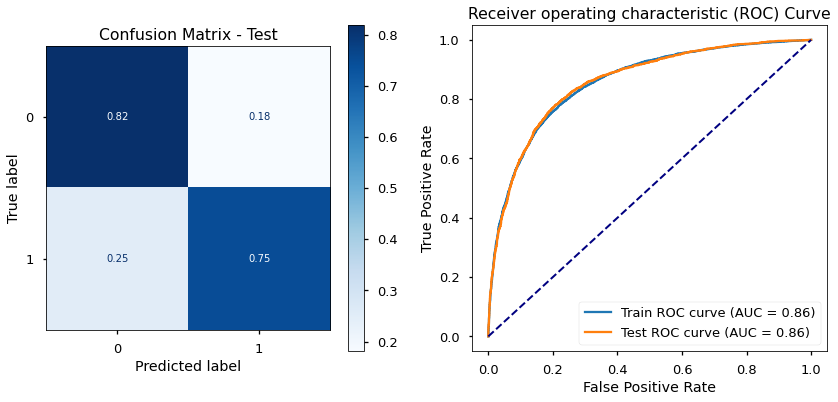



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.795     0.819     0.807      3634
           1      0.776     0.748     0.762      3043

    accuracy                          0.787      6677
   macro avg      0.785     0.783     0.784      6677
weighted avg      0.786     0.787     0.786      6677

--------------------------------------------------------
--------------------------------------------------------


Mean Cross Validated Roc_Auc Score: 85.2553%
Train Roc_Auc Score: 85.5701%
Test Roc_Auc Score: 85.7303%


--------------------------------------------------------
--------------------------------------------------------




In [491]:
bestfit_model_evaluation(best_logreg); # best_logreg.best_estimator_

## KNN neighbours

In [492]:
knn_model = Pipeline([
    ("preprocessor", preprocessor),
    ('knn', KNeighborsClassifier()) 
])

knn_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary_preprocess',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'do...
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                      

In [493]:
baseline_model_evaluation(knn_model);



--------------------------------------------------------
Classification Report - Train Set:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.818     0.831     0.824     10638
           1      0.805     0.790     0.797      9392

    accuracy                          0.812     20030
   macro avg      0.811     0.810     0.811     20030
weighted avg      0.812     0.812     0.812     20030

--------------------------------------------------------
--------------------------------------------------------


Mean Cross Validated Roc_Auc Score: 78.4573%
Train Roc_Auc Score: 89.5615%


--------------------------------------------------------
--------------------------------------------------------




In [496]:
knn_model = Pipeline([
    ("preprocessor", preprocessor),
    ('estimator', KNeighborsClassifier()) # use random state so that your model results are reproducable. 
])


parameters = {
    #'estimator__n_neighbors': list(range(1,50)), # default is 5
    'estimator__metric': ['minkowski', 'manhattan']
    #'estimator__weights': ['uniform', 'distance'],
    #'estimator__leaf_size' : list(range(1,50)),
    #'estimator__p': [1,2]
}

# Create the grid, with "logreg_pipeline" as the estimator
best_knn = GridSearchCV(estimator = knn_model,             # model
                        param_grid = parameters,     # hyperparameters
                        scoring ='roc_auc',          # metric for scoring
                        cv = 5)                      # number of folds for cross-validation

# Train the pipeline (tranformations & predictor)
best_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('binary_preprocess',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home'...
                                                                                                        sparse=False))]),
                                                                         Index(['health_insurance', 'age_group', 'education', 'race', 'sex',
       'income_poverty', 'marital_status', 'rent_or_own', 'employment_

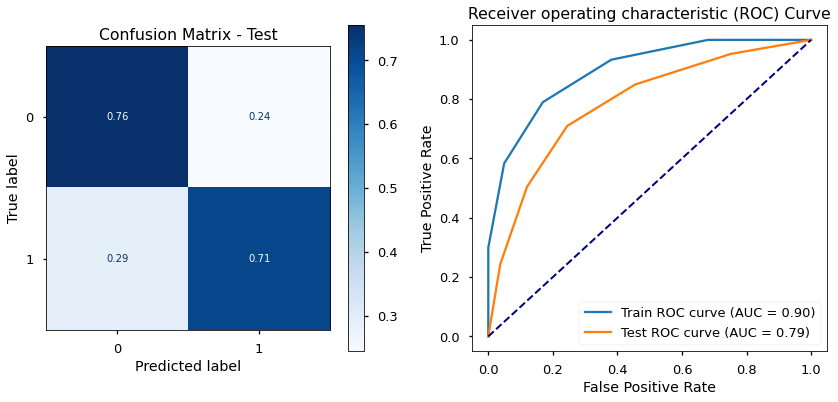



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.757     0.755     0.756      3634
           1      0.708     0.710     0.709      3043

    accuracy                          0.735      6677
   macro avg      0.733     0.733     0.733      6677
weighted avg      0.735     0.735     0.735      6677

--------------------------------------------------------
--------------------------------------------------------


Mean Cross Validated Roc_Auc Score: 78.4573%
Train Roc_Auc Score: 89.5615%
Test Roc_Auc Score: 78.5031%


--------------------------------------------------------
--------------------------------------------------------




In [497]:
bestfit_model_evaluation(best_knn);

## Decision Tree

In [498]:
dTree_model = Pipeline([
    ("preprocessor", preprocessor),
    ('dTree', DecisionTreeClassifier(random_state= 42))
])

dTree_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary_preprocess',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'do...
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['

In [499]:
baseline_model_evaluation(dTree_model)



--------------------------------------------------------
Classification Report - Train Set:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     10638
           1      1.000     1.000     1.000      9392

    accuracy                          1.000     20030
   macro avg      1.000     1.000     1.000     20030
weighted avg      1.000     1.000     1.000     20030

--------------------------------------------------------
--------------------------------------------------------


Mean Cross Validated Roc_Auc Score: 68.5298%
Train Roc_Auc Score: 100.0000%


--------------------------------------------------------
--------------------------------------------------------




In [500]:
dTree_model = Pipeline([
    ("preprocessor", preprocessor),
    ('estimator', DecisionTreeClassifier(random_state= 42)) # use random state so that your model results are reproducable. 
])

parameters = {
    'estimator__criterion': ['gini', 'entropy'],  #DON'T FORGET TWO UNDERSCORES!
    'estimator__max_depth': [None, 2, 3, 4, 5, 6],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

best_dTree = GridSearchCV(estimator = dTree_model,     # model
                          param_grid = parameters,     # hyperparameters
                          scoring ='roc_auc',          # metric for scoring
                          cv = 5)                      # number of folds for cross-validation

best_dTree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('binary_preprocess',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home'...
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employment_occupation'],
      dtype='object'))])),
                                       ('estimator',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'estimator__criterion': ['gini', 'entropy'],
    

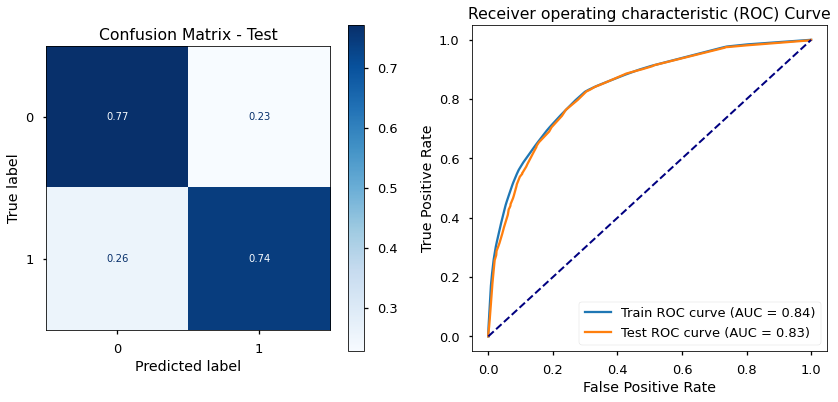



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.782     0.772     0.777      3634
           1      0.732     0.744     0.738      3043

    accuracy                          0.759      6677
   macro avg      0.757     0.758     0.757      6677
weighted avg      0.759     0.759     0.759      6677

--------------------------------------------------------
--------------------------------------------------------


Mean Cross Validated Roc_Auc Score: 83.0833%
Train Roc_Auc Score: 84.0124%
Test Roc_Auc Score: 83.2823%


--------------------------------------------------------
--------------------------------------------------------




In [501]:
bestfit_model_evaluation(best_dTree);

# Gradient Boosting:

### Baseline Model:

In [509]:
gbc_model = Pipeline([
    ("preprocessor", preprocessor),
    ('estimator', GradientBoostingClassifier(random_state= 42))  
])

gbc_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary_preprocess',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'do...
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['

In [510]:
baseline_model_evaluation(gbc_model)



--------------------------------------------------------
Classification Report - Train Set:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.791     0.817     0.804     10638
           1      0.785     0.755     0.770      9392

    accuracy                          0.788     20030
   macro avg      0.788     0.786     0.787     20030
weighted avg      0.788     0.788     0.788     20030

--------------------------------------------------------
--------------------------------------------------------


Mean Cross Validated Roc_Auc Score: 85.6815%
Train Roc_Auc Score: 86.5638%


--------------------------------------------------------
--------------------------------------------------------




### Tuned Best Model:

In [528]:
parameters = {
    "estimator__n_estimators":[5,500],  #[5,50,250,500],
    "estimator__max_depth":[1,9]  #[1,3,5,7,9],
    #"estimator__learning_rate":[0.01,1]  #[0.01,0.1,1,10,100]
}

best_gbc = GridSearchCV(estimator = gbc_model,             # model
                        param_grid = parameters,     # hyperparameters
                        scoring ='roc_auc',          # metric for scoring
                        cv = 5,
                        n_jobs = -1  # run 1 job per core 
)                      

%time best_gbc.fit(X_train, y_train)

CPU times: user 11.6 s, sys: 352 ms, total: 11.9 s
Wall time: 1min 56s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('binary_preprocess',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home'...
                                                                         Index(['health_insurance', 'age_group', 'education', 'race', 'sex',
       'income_poverty', 'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employment_occupation'],
      dtype='objec

In [530]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    "estimator__n_estimators":[5,500],  #[5,50,250,500],
    "estimator__max_depth":[1,9]  #[1,3,5,7,9],
    #"estimator__learning_rate":[0.01,1]  #[0.01,0.1,1,10,100]
}

best_gbc = RandomizedSearchCV(estimator = gbc_model,             # model
                        param_distributions = parameters,     # hyperparameters
                        scoring ='roc_auc',          # metric for scoring
                        cv = 5,
                        n_jobs = -1
)                      

%time best_gbc.fit(X_train, y_train)

CPU times: user 11.9 s, sys: 216 ms, total: 12.2 s
Wall time: 1min 56s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('binary_preprocess',
                                                                               Pipeline(steps=[('simple_imputer',
                                                                                                SimpleImputer(strategy='most_frequent'))]),
                                                                               Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside...
                                                                               Index(['health_insurance', 'age_group', 'education', 'race', 'sex',
       'income_poverty', 'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employm

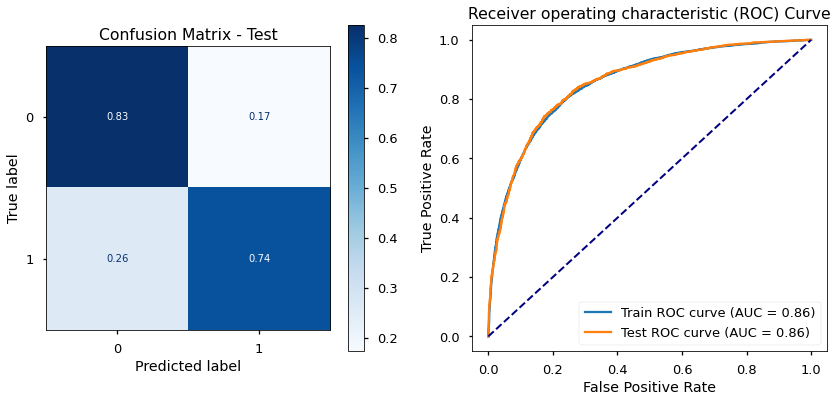



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.793     0.826     0.809      3634
           1      0.781     0.743     0.761      3043

    accuracy                          0.788      6677
   macro avg      0.787     0.784     0.785      6677
weighted avg      0.788     0.788     0.787      6677

--------------------------------------------------------
--------------------------------------------------------


Mean Cross Validated Roc_Auc Score: 85.4821%
Train Roc_Auc Score: 85.6902%
Test Roc_Auc Score: 85.7808%


--------------------------------------------------------
--------------------------------------------------------




In [534]:
bestfit_model_evaluation(best_gbc)

# Random Forest

### Baseline Model:

In [513]:
RF_model = Pipeline([
    ("preprocessor", preprocessor),
    ('estimator', RandomForestClassifier(random_state=42))
])
# Train model
RF_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary_preprocess',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'do...
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['

In [518]:
baseline_model_evaluation(RF_model);



--------------------------------------------------------
Classification Report - Train Set:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     10638
           1      1.000     1.000     1.000      9392

    accuracy                          1.000     20030
   macro avg      1.000     1.000     1.000     20030
weighted avg      1.000     1.000     1.000     20030

--------------------------------------------------------
--------------------------------------------------------


Mean Cross Validated Roc_Auc Score: 84.5559%
Train Roc_Auc Score: 100.0000%


--------------------------------------------------------
--------------------------------------------------------




### Tuned Best Model:

In [537]:
parameters = {
    'estimator__n_estimators': [100], #[10, 30, 100]
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_depth': [None],  #[None, 2, 6, 10]
    'estimator__min_samples_split': [5], #[5, 10],
    'estimator__min_samples_leaf': [6]  #[3, 6]
}

best_RF = GridSearchCV(estimator = RF_model,   # model
                        param_grid = parameters,     # hyperparameters
                        scoring ='roc_auc',          # metric for scoring
                        cv = 5,
                        n_jobs = 10)                      

# Train the pipeline (tranformations & predictor)
best_RF.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('binary_preprocess',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home'...
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employment_occupation'],
      dtype='object'))])),
                                       ('estimator',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=10,
             param_grid={'estimator__criterion': [

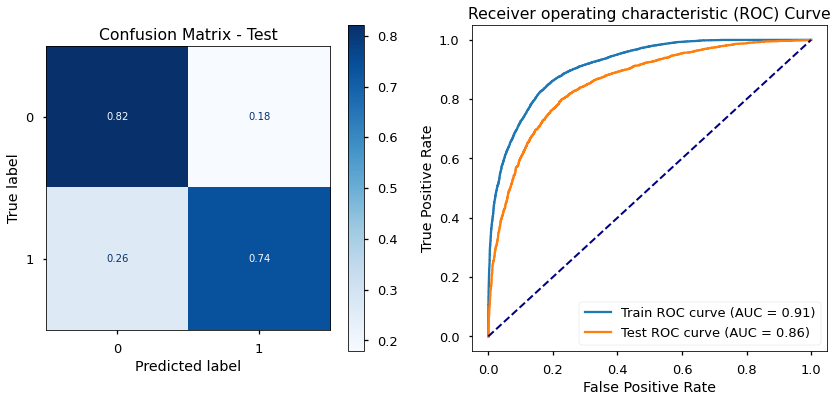



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.790     0.821     0.805      3634
           1      0.776     0.739     0.757      3043

    accuracy                          0.784      6677
   macro avg      0.783     0.780     0.781      6677
weighted avg      0.784     0.784     0.783      6677

--------------------------------------------------------
--------------------------------------------------------


Mean Cross Validated Roc_Auc Score: 85.1519%
Train Roc_Auc Score: 91.4061%
Test Roc_Auc Score: 85.6990%


--------------------------------------------------------
--------------------------------------------------------




In [538]:
bestfit_model_evaluation(best_RF)

# XG Boost:

### Baseline Model:

In [516]:
xgb_model = Pipeline([
    ("preprocessor", preprocessor),
    ('estimator', XGBClassifier(objective= 'binary:logistic', nthread=4, seed=42))
])

# Train model
xgb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary_preprocess',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'do...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, nthread=4, num_parallel_tree=1,
              

In [539]:
baseline_model_evaluation(xgb_model)



--------------------------------------------------------
Classification Report - Train Set:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.868     0.882     0.875     10638
           1      0.864     0.848     0.856      9392

    accuracy                          0.866     20030
   macro avg      0.866     0.865     0.866     20030
weighted avg      0.866     0.866     0.866     20030

--------------------------------------------------------
--------------------------------------------------------


Mean Cross Validated Roc_Auc Score: 84.4278%
Train Roc_Auc Score: 94.1176%


--------------------------------------------------------
--------------------------------------------------------




### Tuned Best Model:

In [541]:
parameters = {
    'estimator__max_depth': [4],    #range (2, 12, 2),
    'estimator__n_estimators': [100],    #range(60, 220, 40),
    'estimator__learning_rate': [0.1, 0.05],   #[0.3, 0.1, 0.01, 0.05],
    'estimator__min_child_weight': [1,5],   #[1,5,15],
    'estimator__subsample': [0.5, 1],    #[0.5, 0.75, 1],
    'estimator__gamma': [1, 2],    #[0.5, 1, 1.5, 2, 5],
    'estimator__colsample_bytree':[0.5,1]    #[0.5, 0.75, 1]
}

best_xgb = GridSearchCV(estimator = xgb_model,   # model
                        param_grid = parameters,     # hyperparameters
                        scoring ='roc_auc',          # metric for scoring
                        cv = 5,
                        n_jobs =-1
)                      

# Train the pipeline (tranformations & predictor)
best_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('binary_preprocess',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home'...
                                                      scale_pos_weight=1,
                                                      seed=42, subsample=1,
                                                      tree_method='exact',
                                                      validate_parameters=1,
                               

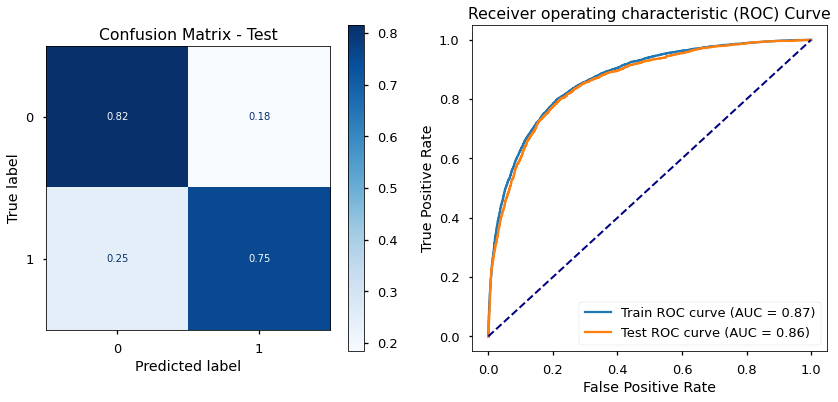



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.798     0.816     0.807      3634
           1      0.774     0.754     0.764      3043

    accuracy                          0.787      6677
   macro avg      0.786     0.785     0.785      6677
weighted avg      0.787     0.787     0.787      6677

--------------------------------------------------------
--------------------------------------------------------


Mean Cross Validated Roc_Auc Score: 85.7162%
Train Roc_Auc Score: 86.9755%
Test Roc_Auc Score: 86.1377%


--------------------------------------------------------
--------------------------------------------------------




In [542]:
bestfit_model_evaluation(best_xgb)

# Overall Comparison of Different Modeling Techniques:

In [546]:
names = ["Logistic Regression", "KNN","Decision Tree", "Gradient Boost", "Random Forest", "XG Boost"]
models = [best_logreg, best_knn, best_dTree, best_gbc, best_RF, best_xgb]

scores = []
for i in range(len(names)):
    score = models[i].best_estimator_.score(X_test, y_test)   
    scores.append(score)   
    print(names[i]+" accuracy = "+str(scores[i]))

Logistic Regression accuracy = 0.7865807997603714
KNN accuracy = 0.7346113524037742
Decision Tree accuracy = 0.7590235135539913
Gradient Boost accuracy = 0.7879287104987269
Random Forest accuracy = 0.7838849782836603
XG Boost accuracy = 0.7874794069192751


In [553]:
names = ["Logistic Regression", "KNN","Decision Tree", "Gradient Boost", "Random Forest", "XG Boost"]
models = [best_logreg, best_knn, best_dTree, best_gbc, best_RF, best_xgb]

scores = []
for i in range(len(names)):
    y_pred = models[i].best_estimator_.predict(X_test)
    score = accuracy_score(y_test, y_pred)   
    scores.append(score)   
    print(names[i]+" accuracy = "+str(scores[i]))

Logistic Regression accuracy = 0.7865807997603714
KNN accuracy = 0.7346113524037742
Decision Tree accuracy = 0.7590235135539913
Gradient Boost accuracy = 0.7879287104987269
Random Forest accuracy = 0.7838849782836603
XG Boost accuracy = 0.7874794069192751


In [554]:
names = ["Logistic Regression", "KNN","Decision Tree", "Gradient Boost", "Random Forest", "XG Boost"]
models = [best_logreg, best_knn, best_dTree, best_gbc, best_RF, best_xgb]

scores = []
for i in range(len(names)):
    y_pred = models[i].best_estimator_.predict(X_test)
    score = precision_score(y_test, y_pred)   
    scores.append(score)   
    print(names[i]+" precision = "+str(scores[i]))

Logistic Regression precision = 0.7755449591280654
KNN precision = 0.7084289931124959
Decision Tree precision = 0.731888745148771
Gradient Boost precision = 0.7811959903214656
Random Forest precision = 0.7758620689655172
XG Boost precision = 0.7739541160593792


In [555]:
names = ["Logistic Regression", "KNN","Decision Tree", "Gradient Boost", "Random Forest", "XG Boost"]
models = [best_logreg, best_knn, best_dTree, best_gbc, best_RF, best_xgb]

scores = []
for i in range(len(names)):
    y_pred = models[i].best_estimator_.predict(X_test)
    score = recall_score(y_test, y_pred)   
    scores.append(score)   
    print(names[i]+" recall = "+str(scores[i]))

Logistic Regression recall = 0.7482747288859678
KNN recall = 0.70982582977325
Decision Tree recall = 0.7436740059152153
Gradient Boost recall = 0.7426881367071968
Random Forest recall = 0.7394019060138022
XG Boost recall = 0.7538613210647388


In [ ]:
# Find Scores
 
        true = y
        pred = model.predict(X)
        pred_proba = model.predict_proba(X)[:, 1]
        
        roc_score = roc_auc_score(true, pred_proba)
        precision = precision_score(true, pred)
        recall = recall_score(true, pred)
        accuracy = accuracy_score(true, pred)
        f1 = f1_score(true, pred)
        
        # Print Scores
        divider = ('----' * 6) 
        scores_title = 'Summary Scores for being Classified as Getting the Vaccine:'
        scores_table = {'Roc_Auc': [roc_score], 'Precision': [precision],'Recall':[recall], 'Accuracy': [accuracy], 'F1':[f1]}
        scores_table = pd.DataFrame.from_dict(scores_table, orient='index')
        scores_table.columns = ['Scores']
        print('\n', divider, scores_title, divider, scores_table, divider, divider, '\n' , sep='\n') 
        

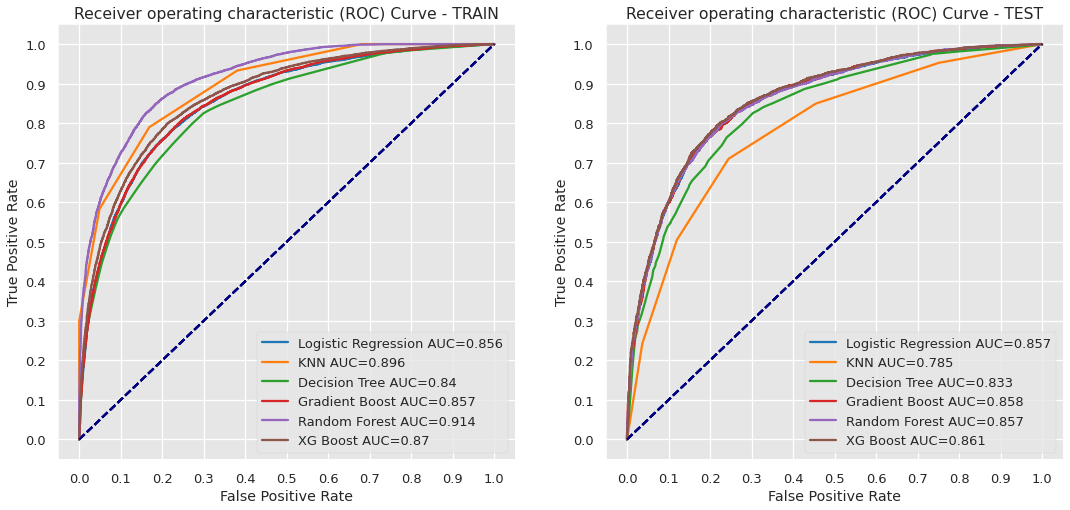

In [544]:
with plt.style.context('seaborn-talk'):
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols =2, figsize=(18, 8))
    
    names = ["Logistic Regression", "KNN","Decision Tree", "Gradient Boost", "Random Forest", "XG Boost"]
    models = [best_logreg, best_knn, best_dTree, best_gbc, best_RF, best_xgb]
    
    for i in range(len(names)):
        
    # fit logistic regression model and plot ROC curve
    # model = LogisticRegression()
    # model.fit(X_train, y_train)
        y_pred = models[i].predict_proba(X_train)[:, 1]
        fpr, tpr, _ = roc_curve(y_train, y_pred)
        auc = round(roc_auc_score(y_train, y_pred), 3)
        ax1.plot(fpr,tpr,label= names[i]+" AUC="+str(auc))
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.05])
        ax1.set_ylim([-0.05, 1.05])
        ax1.set_yticks([i/10.0 for i in range(11)])
        ax1.set_xticks([i/10.0 for i in range(11)])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('Receiver operating characteristic (ROC) Curve - TRAIN')
        ax1.legend()
        
    for i in range(len(names)):
        
        y_pred = models[i].predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc = round(roc_auc_score(y_test, y_pred), 3)
        ax2.plot(fpr,tpr,label= names[i]+" AUC="+str(auc))
        ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax2.set_xlim([-0.05, 1.05])
        ax2.set_ylim([-0.05, 1.05])
        ax2.set_yticks([i/10.0 for i in range(11)])
        ax2.set_xticks([i/10.0 for i in range(11)])
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('Receiver operating characteristic (ROC) Curve - TEST')
        ax2.legend()
        

In [542]:
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

NameError: name 'model_selection' is not defined

## NEW DATA SET DF_INSRUANCE

In [7]:
df_insurance = df.dropna(subset = ['health_insurance'], axis=0)
df_insurance.shape

(14433, 30)

In [8]:
df_insurance['seasonal_vaccine'] =  df_insurance['seasonal_vaccine'].astype('float64') # to allign with other predcitor variables
df_insurance['health_insurance'] =  df_insurance['health_insurance'].astype('int64') # this is the targte variable, easier if it is integer
df_insurance['health_insurance'].dtype

dtype('int64')


- What other variable in the dataset health_insurance correlate with at the highest level?
- It seems like the majority of the people who had a doctor recommend them the vaccine, also had health insurance
- This makes sense given that those who go to the doctors usually have health insurance as well. 
- It also seems like the majority of those with a dcotor not recommending the vaccine alaso have health insurance. Although it is a t lower extent. 
- It would be hard to inmpute a value based ont his variable only.
- Ideally we shoudl have taken into considerancation all possibly relevant variables (such as income, race, education etc). to be able to make our best guess. 
- For this project I will treat the Null values as a seperate category thinking that it is a specifgic category of people who denied an answer to that question, since it does not feel like replacing them all with either 0 or 1. 
- Because nearly half (44.2%) of respondents declined to disclose whether they have health_insurance, this 'missing' information will become its own category for this variable.
- For the categorical variables: null values for these categorical variables will be filled with 'missing' as its own category since this missing information appears to represent a specific type of survey respondent.

### Let's try to impute some meaningful numbers for the null values of `health_insurance` using logistic regression: 

In [12]:
X_insurance_train = df_insurance.drop('health_insurance', axis = 1)
y_insurance_train = df_insurance['health_insurance']
print(X_insurance_train.shape)
print(y_insurance_train.shape)

(14433, 29)
(14433,)


In [13]:
X_insurance_test = df[df['health_insurance'].isna()].drop('health_insurance', axis = 1)
# y_insurance_test is all null
print(X_insurance_test.shape)

(12274, 29)


## Preprocessing Steps:
- **NA imputation** for both ordinal/numerical and categorical variables
    * For the ordinal variables, let's impute with the median.
    * For the categorical variables, let's impute with the most frequent. 
- **One-Hot-Encoding** for the categorical variables
- **Scaling** for the ordinal/numerical variables

In [14]:
X_insurance_train_nums = X_insurance_train.select_dtypes('float64')
X_insurance_train_cats = X_insurance_train.select_dtypes('object')

In [15]:
# Creat a pipeline for the preprocessing steps. We will keep the same piperline for all out analysis.
numerical_preprocessing = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_preprocessing = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(drop='first', sparse=False))
])

preprocessor = ColumnTransformer(transformers=[  #grab columns out of a pandas data frame and then apply a specified transformer.
    ('num_preprocess', numerical_preprocessing, X_insurance_train_nums.columns),
    ('cat_preprocess', categorical_preprocessing, X_insurance_train_cats.columns)] # remainder='passthrough'
)

## Modeling Steps:
- **preprocessing** as described above. 
    * For the ordinal variables, let's impute with the median.
    * For the categorical variables, let's impute with the most frequent. 
- **Smote** due to inbalanced target categories
- **Estimator** is logistic regression. 

In [16]:
knn_insurance = Pipeline([
    ('preprocess', preprocessor),
    ('knn', KNeighborsClassifier()) # use random state so that your model results are reproducable. 
])

# Train model
knn_insurance.fit(X_insurance_train, y_insurance_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_preprocess',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral...
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
    

In [351]:
y_hat_train = knn_insurance.predict(X_insurance_train)
y_hat_test = knn_insurance.predict(X_insurance_test)

print(accuracy_score(y_insurance_train, y_hat_train))

0.9025150696320932


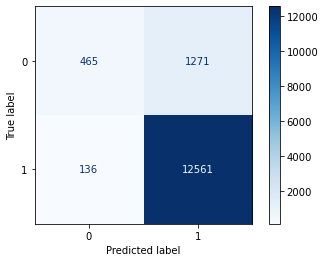

In [352]:
plot_confusion_matrix(knn_insurance, X_insurance_train, y_insurance_train,  cmap = 'Blues'); 

In [353]:
# Usually, you use precision, recall, and F1 to evaluate the (generalization) performance of your model. Therefore, you compute these on the test set.

y_hat = knn_insurance.predict(X_insurance_train)
print(classification_report(y_insurance_train, y_hat, target_names=['0', '1']))


              precision    recall  f1-score   support

           0       0.77      0.27      0.40      1736
           1       0.91      0.99      0.95     12697

    accuracy                           0.90     14433
   macro avg       0.84      0.63      0.67     14433
weighted avg       0.89      0.90      0.88     14433



In [ ]:
# Replace Nones in list 2 with elements from list 1
> lis1 = [2, 3, 6, 8]
> lis2 = [1, None, None, 4, 5, None, 7, None]

# Index of next element to use from list 1
> j = 0

> for i in range(len(lis2)):
    if lis2[i] == None:
        lis2[i] = lis1[j]  # Replace a None with something from list 1
        j += 1  # Use the following element next time

> lis2
[1, 2, 3, 4, 5, 6, 7, 8]

In [37]:
# this code is not working: df_new['health_insurance'].iloc[i] == None, you need to use np.isnan
j=0
for i in range(len(df_new)):
    if np.isnan(df_new['health_insurance'].iloc[i]):
        df_new['health_insurance'].iloc[i] = predict_cat[j]
        j += 1
df_new['health_insurance'].isnull().sum()


0

In [270]:
# df['health_insurance_imputed'] = df['health_insurance']
# mask1 = ( df['health_insurance'].isnull() & (df['doctor_recc_seasonal'] == 1))
# mask2 = ( df['health_insurance'].isnull() & (df['doctor_recc_seasonal'] != 0))
# df.loc[mask1,'health_insurance_imputed'] = 1
# df.loc[mask2,'health_insurance_imputed'] = 0

In [17]:
# Predict on test set using probabilities
predict_cat = knn_insurance.predict(X_insurance_test) 
predict_cat
# It predicts almost all of them as 1!!!! Because majority is 1?

array([1, 1, 1, ..., 1, 1, 1])

In [179]:
counter = Counter(y_insurance_train)
counter

from collections import Counter
counter = Counter(y_insurance_train)
counter

Counter({0: 1272, 1: 9552})

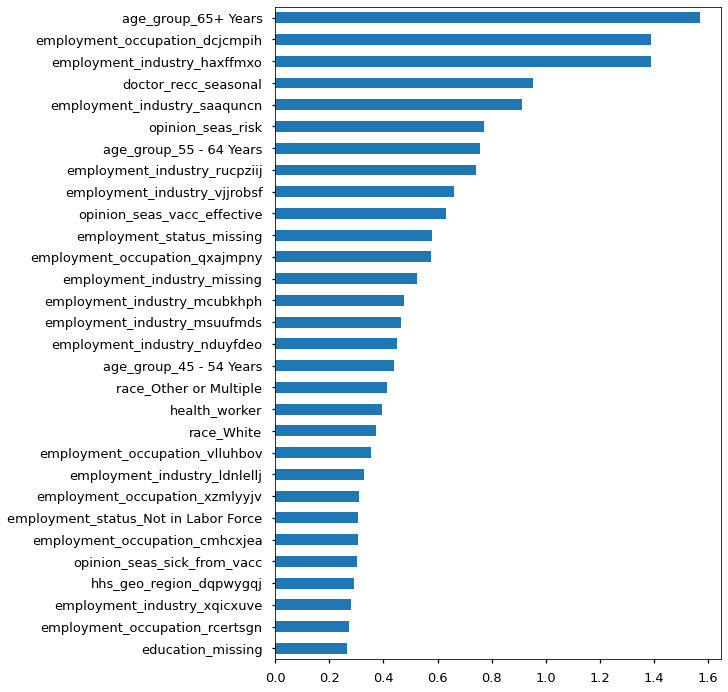

In [208]:
# logreg_model = name of the model pipeline
# estimator = name of the estimator in the pipeline

def feature_importance_logreg(model):
    logreg_coeffs = model.named_steps['estimator'].coef_ 
    importance = pd.Series(abs(logreg_coeffs[0]), index=feature_names) # logreg_coeffs[0] = getting the one-dim list inside the list
    with plt.style.context('seaborn-talk'):
        fig, ax = plt.subplots(figsize=(8,12))
        importance.sort_values().tail(30).plot.barh(ax=ax);
        
feature_importance_logreg(logreg_model)


In [374]:
# Predict on test set using probabilities
predict_cat = logreg_pipeline.predict(X_test) 
print(predict_cat)
preds = logreg_pipeline.predict_proba(X_test)
preds

[0 0 1 ... 0 0 1]


array([[0.78026967, 0.21973033],
       [0.81746699, 0.18253301],
       [0.13929558, 0.86070442],
       ...,
       [0.67083071, 0.32916929],
       [0.59538476, 0.40461524],
       [0.1706102 , 0.8293898 ]])

In [375]:
# What is the probability that the person would get the vaccine, target =1:
y_preds = pd.DataFrame(
    {"seasonal_vaccine": preds[:,1]}, index = y_test.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (6677, 1)


,seasonal_vaccine
15772,0.219730
9407,0.182533
16515,0.860704
23353,0.226891
10008,0.250274


In [ ]:
'''
models = ['logreg', 'knn', 'dtree', 'RF', 'GBC', 'XGBoost']
estimators = [LogisticRegression(random_state =42), KNeighborsClassifier(), DecisionTreeClassifier(),
             RandomForestClassifier(), GradientBoostingClassifier(), XGBClassifier(random_state=42)]


for i in range(len(models)):
    model = Pipeline([
        ("preprocessor", preprocessor),
        (models[i], estimators[i]) 
    ])

    model.fit(X_train, y_train)
    scores = []
    scores.append(model.score(X_train, y_train))
print(scores)
'''

In [725]:
from sklearn.metrics import roc_curve, auc
# Calculate the probability scores of each point in the training set
y_train_score = knn_model.decision_function(X_train)
# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)
# Calculate the probability scores of each point in the test set
y_test_score = knn_model.decision_function(X_test)
# Calculate the fpr, tpr, and thresholds for the test set
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

AttributeError: 'KNeighborsClassifier' object has no attribute 'decision_function'

In [ ]:
plt.figure(figsize=(10, 8))
lw = 2

plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Train ROC curve')
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()